# Complex source reconstruction using _starlets_ with point sources

The complex source surface brightness is solved using sparsity constrains in starlets space, and the linear amplitude of point sources (lensed quasar images) are optimized through weight least square (as in *lenstronomy*).

In [1]:
__author__ = 'aymgal'

%matplotlib inline

import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')

import os
import sys
import copy
import time
import pprint
import pickle as pkl
import numpy as np
import astropy.io.fits as pf
from matplotlib.colors import LogNorm

from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Util import kernel_util
from lenstronomy.Util import param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar

subgrid_res_source = 3
mock_psf_type = 'hst_j1537'  # 'gaussian' or 'hst_tinytim' or 'hst_j1537'

np.random.seed(18)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad('black')
cmap_res = copy.copy(plt.get_cmap('RdBu_r'))

## Generate a mock lens

In [3]:
# data specifics
num_pix = 100  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.1  # background noise per pixel
exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_error_level = 0.01
inaccurate_psf = True

filename_psf_tdlmc = 'psf_tdlmc_rung0.fits'
filename_psf_j1537_stars = 'psf_j1537_f160w_stacked_stars.fits'
filename_psf_j1537_recon = 'psf_j1537_f160w_stacked_recon.fits'


In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(61, 61) 1.0


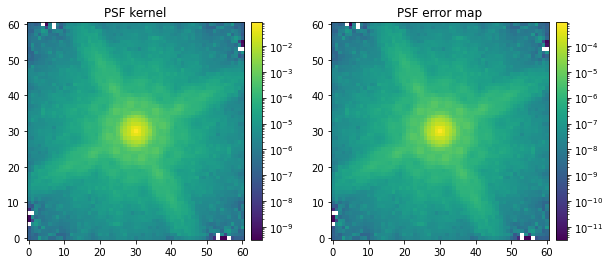

In [5]:
# load HST PSF kernel
if mock_psf_type == 'hst_tinytim':
    with pf.open(os.path.join('data', 'psf', filename_psf_tdlmc)) as f:
        psf_kernel_hst_raw = f[0].data
if mock_psf_type == 'hst_j1537':
    with pf.open(os.path.join('data', 'psf', filename_psf_j1537_recon)) as f:
        psf_kernel_hst_raw = f[0].data
psf_num_pix = 61
psf_kernel_hst = kernel_util.cut_psf(psf_kernel_hst_raw, psf_num_pix)

# PSF specification
if mock_psf_type in ['hst_tinytim', 'hst_j1537']:
    print(psf_kernel_hst.shape, psf_kernel_hst.sum())
    kwargs_psf = {
        'psf_type': 'PIXEL', 
        'kernel_point_source': psf_kernel_hst,
        'kernel_point_source_init': np.copy(psf_kernel_hst),
    }
elif mock_psf_type == 'gaussian':
    psf_fwhm = kernel_util.fwhm_kernel(psf_kernel_hst) * delta_pix
    print("estimated FWHM", psf_fwhm)
    psf_kernel_gauss = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel_gauss.shape, psf_kernel_gauss.sum())
    kwargs_psf = {
        'psf_type': 'PIXEL', 
        'kernel_point_source': psf_kernel_gauss,
        'kernel_point_source_init': np.copy(psf_kernel_gauss),
    }
if psf_error_level > 0:
    # set the relative level of uncertainty in PSF kernel pixels
    psf_error_map = psf_error_level * np.ones((psf_num_pix, psf_num_pix))
    kwargs_psf['psf_error_map'] = psf_error_map
    
psf_class = PSF(**kwargs_psf)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title("PSF kernel")
im = ax.imshow(psf_class.kernel_point_source, cmap='viridis', norm=LogNorm())
nice_colorbar(im)
if 'psf_error_map' in kwargs_psf:
    ax = plt.subplot(1, 2, 2)
    ax.set_title("PSF error map")
    im = ax.imshow(psf_class.psf_error_map * psf_class.kernel_point_source, cmap='viridis', norm=LogNorm())
    nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['PEMD', 'SHEAR_GAMMA_PSI']
kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_shear = {'gamma_ext': 0.05, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
# get an pre-processed source galaxy from galsim
galsim_index = 31
snr = 500
galsim_data_path = ('/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code' +
                    '/Lens_modelling/gravlensgen/Simulations/ring_sims' +
                    '/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr, galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
scale = galsim_delta_pix/4  # galsim_delta_pix/3
kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                          'scale': scale}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# add point sources : solve lens equation from source position to find images
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(kwargs_source[0]['center_x'], 
                                                      kwargs_source[0]['center_y'], 
                                                      kwargs_lens, numImages=4,
                                                      min_distance=delta_pix, 
                                                      search_window=num_pix*delta_pix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag_factor = 100
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
              'point_amp': mag_factor*np.abs(mag)}]
num_ps = len(kwargs_ps[0]['point_amp'])
print(kwargs_ps)

kwargs_special = {}

point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

[{'ra_image': array([ 1.93029752, -0.02402909,  1.08273339, -1.11603544]), 'dec_image': array([ 0.99330648, -1.88873789, -1.49990435,  0.66386942]), 'point_amp': array([319.18460747, 672.64513689, 611.19244823, 127.53846181])}]


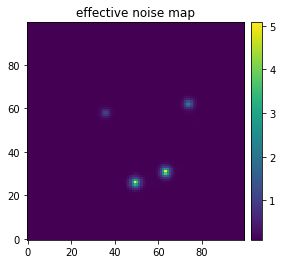

In [7]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
# using ImageLinearFit instead of ImageModel in order to access the full noise map (including PS error maps)
imageModel = ImageLinearFit(data_class, psf_class, lens_model_class, source_model_class, 
                            lens_light_model_class, point_source_class=point_source_class, 
                            kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

# update classes with the newly simulated image
kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

imageModel = ImageLinearFit(data_class, psf_class, lens_model_class, source_model_class, 
                            lens_light_model_class, point_source_class=point_source_class, 
                            kwargs_numerics=kwargs_numerics)

# access full effective noise map
C_D_matrix, _ = imageModel.error_response(kwargs_lens, kwargs_ps, kwargs_special)
effective_noise_map = np.sqrt(imageModel.array_masked2image(C_D_matrix))

plt.title("effective noise map")
im = plt.imshow(effective_noise_map)
nice_colorbar(im)
plt.show()

In [8]:
# get the light distribution in source plane
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

# get the light distribution in source plane convolved
source_sim_conv = imageModel.source_surface_brightness(kwargs_source, unconvolved=False, de_lensed=True)
source_sim_1d_conv = lenstro_util.image2array(source_sim)
    
# get the point source model, for initial guess
init_ps_model = imageModel.point_source(kwargs_ps)

In [9]:
# some quantities for Molet
print(os.path.basename(galsim_data_path))
phi, q = param_util.ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
print("phi, q:", phi*180./np.pi, q)
radec0 = data_class.radec_at_xy_0
print("lower-left corner", radec0)
print("source number of pixels on a side:", len(galsim_source_highres))
print("source scale:", kwargs_interpol_source['scale'])
xmin = kwargs_interpol_source['center_x']-kwargs_interpol_source['scale']*len(galsim_source_highres)/2.-radec0[0]
xmax = kwargs_interpol_source['center_x']+kwargs_interpol_source['scale']*len(galsim_source_highres)/2.-radec0[0]
ymin = kwargs_interpol_source['center_y']-kwargs_interpol_source['scale']*len(galsim_source_highres)/2.-radec0[1]
ymax = kwargs_interpol_source['center_y']+kwargs_interpol_source['scale']*len(galsim_source_highres)/2.-radec0[1]
print("source cutout:", xmin, xmax, ymin, ymax)
F_tot = kwargs_interpol_source['amp']*np.sum(kwargs_interpol_source['image'])*delta_pix**2
print("M_tot", -2.5*np.log10(F_tot))

#plt.imshow(image_sim_no_noise, norm=LogNorm(), extent=[0, num_pix*delta_pix, 0, num_pix*delta_pix])
#plt.scatter([xmin, xmax], [ymin, ymax])
#plt.xlim(0, num_pix*delta_pix)
#plt.ylim(0, num_pix*delta_pix)
#plt.show()

simring_galsim31_all.pkl
phi, q: -31.717474411461005 0.6345120047368864
lower-left corner (-3.96, -3.96)
source number of pixels on a side: 297
source scale: 0.02
source cutout: 1.2899999999999996 7.23 0.8899999999999997 6.83
M_tot -8.378798929803885


## Visualize the lens & true source

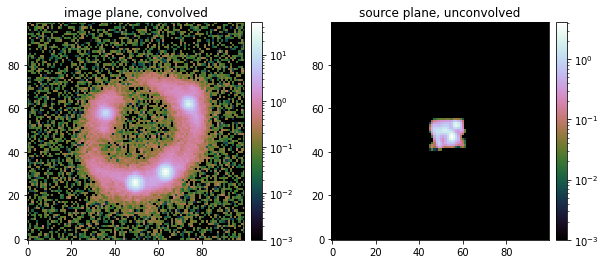

In [10]:
fig = plt.figure(figsize=(10, 4))

ax = plt.subplot2grid((1, 2), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), cmap=cmap_flux, norm=LogNorm(1e-3))
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), cmap=cmap_flux, norm=LogNorm(1e-3))
nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

#### Alter the PSF kernel to test the robustness of the reconstruction

check norm 0.9999999999999999


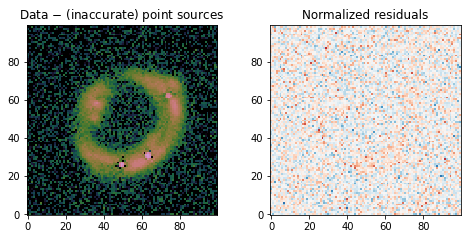

In [11]:
kwargs_ps_sparsefit = copy.deepcopy(kwargs_ps)

# disturb initial amplitudes w.r.t. truth
#kwargs_ps_sparsefit[0]['point_amp'] += 20 * np.random.randn(num_ps)

# increase central value of the PSF kernel to fake bad modelling
psf_class_sparsefit = copy.deepcopy(psf_class)
if inaccurate_psf is True:
    # here we alter some pixels of the PSF kernel to mimick a bad PSF model
    if mock_psf_type in ['gaussian', 'hst_tinytim']:
        # in this case we alter the central pixel value
        original_kernel = psf_class.kernel_point_source
        altered_psf_kernel = np.copy(original_kernel)
        altered_psf_kernel[psf_num_pix//2, psf_num_pix//2] *= 0.5
        altered_psf_kernel /= altered_psf_kernel.sum()  # make sure kernel is normnalised
        
    elif mock_psf_type == 'hst_j1537':
        # in the case we replace the PSF kernel with the real (inaccurate) model from J1537
        with pf.open(os.path.join('data', 'psf', filename_psf_j1537_stars)) as f:
            altered_psf_kernel = f[0].data
            
    # we force the PSF kernel to change (TODO: not ideal as it is a private attribute...)
    print("check norm", altered_psf_kernel.sum())
    psf_class_sparsefit._kernel_point_source = altered_psf_kernel


    # here we juste recreate a ImageModel object with the PSF class containing the altered PSF
    imageModel_alt = ImageModel(data_class, psf_class_sparsefit, lens_model_class, source_model_class, 
                                lens_light_model_class, point_source_class=point_source_class, 
                                kwargs_numerics=kwargs_numerics)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    ax = axes[0]
    ax.set_title("Data $-$ (inaccurate) point sources")
    ax.imshow(data_class.data - imageModel_alt.point_source(kwargs_ps_sparsefit), 
               cmap=cmap_flux, norm=LogNorm(1e-2, 1e2))
    ax = axes[1]
    ax.set_title("Normalized residuals")
    ax.imshow((imageModel_alt.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source, 
                                kwargs_ps=kwargs_ps_sparsefit, lens_light_add=False) - data_class.data) / effective_noise_map, 
               cmap=cmap_res, vmin=-5, vmax=5)
    plt.show()

In [12]:
source_model_list_sparsefit = ['SLIT_STARLETS']
kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

# TEST: displace PS positions
#kwargs_ps_sparsefit[0]['ra_image'] += delta_pix/10. * np.random.randn(num_ps)
#kwargs_ps_sparsefit[0]['dec_image'] += delta_pix/10. * np.random.randn(num_ps)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

kwargs_pixelbased = {
    'include_point_source_error': True,
    'filter_point_source_residuals': True,
    'min_scale_point_source_residuals': 2,
    'radius_point_source_residuals': 0.3,
    'check_point_source_residuals': True,
    
    'supersampling_factor_source': subgrid_res_source,
    'minimal_source_plane': True,
    'min_threshold': 3,
    'threshold_increment_high_freq': 2,
    'num_iter_source': 50,
    'num_iter_global': 5,
    'num_iter_weights': 2,
    'verbose': False,
    'show_steps': False,
    'thread_count': 8,
}

imageSparseFit = ImageLinearFit(data_class, psf_class=psf_class_sparsefit, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                point_source_class=point_source_class,
                                likelihood_mask=None,
                                kwargs_pixelbased=kwargs_pixelbased)


In [13]:
print("Before optimisation:")
print("truth", kwargs_ps[0]['point_amp'])
print("model", kwargs_ps_sparsefit[0]['point_amp'])
print("RMS error", np.sum((kwargs_ps[0]['point_amp'] - kwargs_ps_sparsefit[0]['point_amp'])**2) / num_ps)

Before optimisation:
truth [319.18460747 672.64513689 611.19244823 127.53846181]
model [319.18460747 672.64513689 611.19244823 127.53846181]
RMS error 0.0


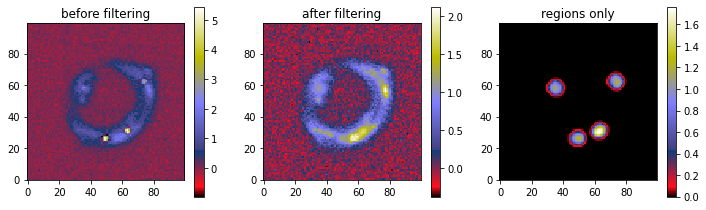

Runtime : 2.477 s


In [14]:
start_time = time.time()
model, _, _, param = imageSparseFit.image_pixelbased_solve(copy.deepcopy(kwargs_lens), 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_ps=kwargs_ps_sparsefit,
                                                       kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

In [15]:
print("After optimisation:")
print("truth", kwargs_ps[0]['point_amp'])
print("model", kwargs_ps_sparsefit[0]['point_amp'])
print("RMS error", np.sum((kwargs_ps[0]['point_amp'] - kwargs_ps_sparsefit[0]['point_amp'])**2) / num_ps)

After optimisation:
truth [319.18460747 672.64513689 611.19244823 127.53846181]
model [319.18460747 672.64513689 611.19244823 127.53846181]
RMS error 0.0


## Plot optimization summary

Negative image pixels ? False (min = 2.29e-04)
Negative source pixels ? False (min = 0.00e+00)


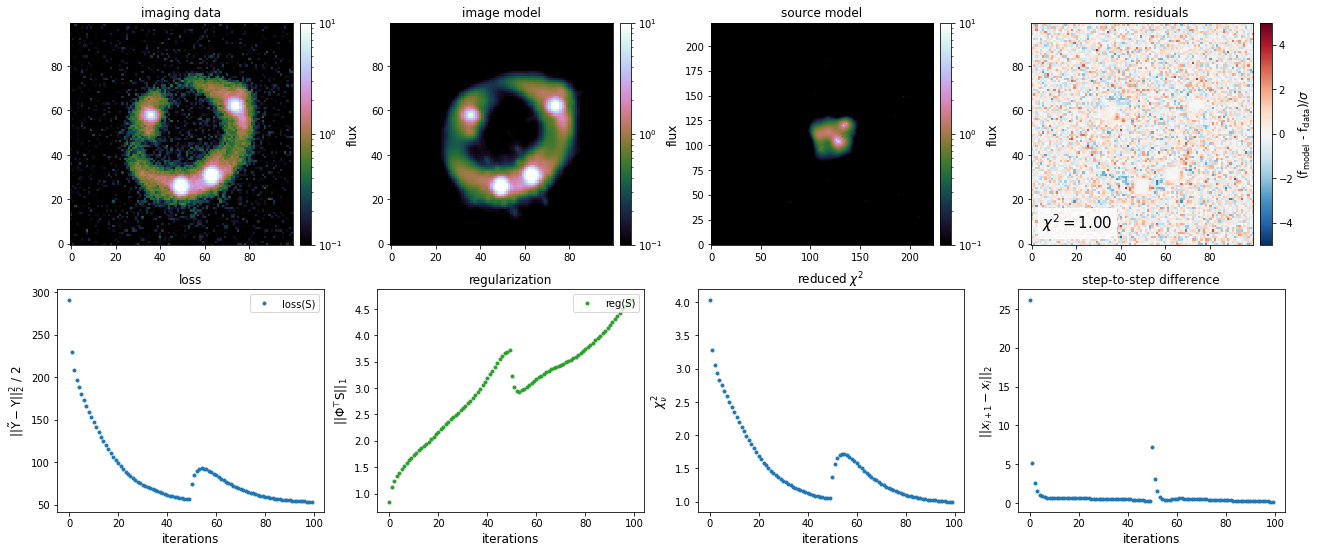

In [16]:
sparseSolver = imageSparseFit.PixelSolver
#lensingOperator = imageSparseFit.lensingOperator

fig = sparseSolver.plot_results(log_scale=True, vmin_res=-5, vmax_res=5, 
                                point_source_add=True,
                                cmap_image=cmap_flux, cmap_source=cmap_flux,
                                vmin_image=1e-1, vmin_source=1e-1,
                                vmax_image=1e1, vmax_source=1e1)

## Plot residuals in source plane

In [17]:
# get source reconstructions
source_estimate = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=None, 
                                                           unconvolved=True, de_lensed=True)

ra_grid_hd, dec_grid_hd = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix,
                                                 subgrid_res=subgrid_res_source)
#ra_grid_hd, dec_grid_hd = sparseSolver.lensingOperator.sourcePlane.grid()
source_estimate_hd = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estimate_hd = lenstro_util.array2image(source_estimate_hd)

# get the true light distribution in source plane on high res grid
source_sim_hd = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_hd)
source_sim_hd *= (delta_pix/subgrid_res_source)**2  # unit conversion
source_sim_hd *= subgrid_res_source**2  # pixeal area ratio

model_unconvolved = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit, kwargs_lens=kwargs_lens,
                                                                  unconvolved=True, de_lensed=False)

SDR = 6.6105155195375565
SDR (restricted) = 6.686230113814407
SDR (HD, restricted) = -24.258474290202372
QOR = 1.146795643907103
4.096000099182123 3.5525894396834783 4.096000099182128 7.134619235992323


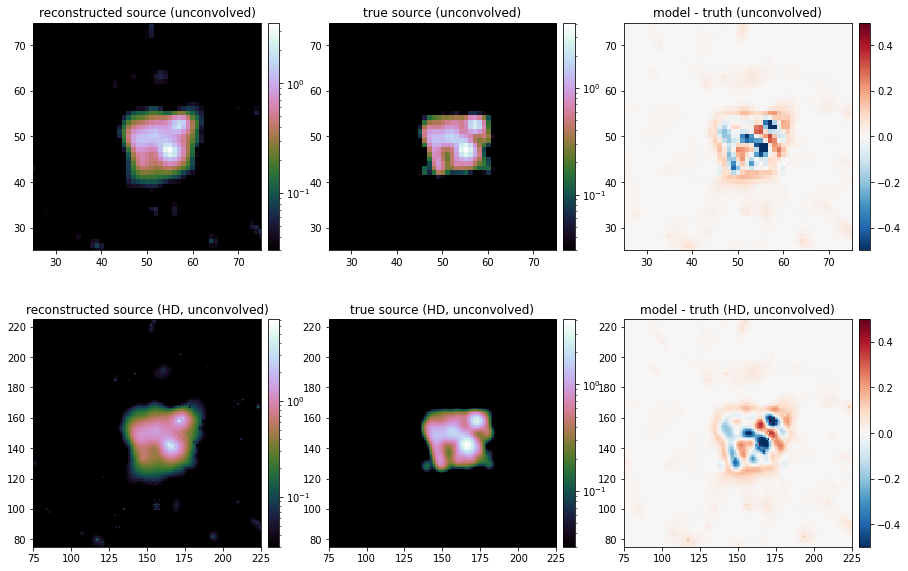

In [18]:
from metrics import SDR, QOR
print("SDR =", SDR(source_sim, source_estimate))
print("SDR (restricted) =", SDR(source_sim[33:63, 38:68], source_estimate[33:63, 38:68]))
print("SDR (HD, restricted) =", SDR(source_sim_hd[66:126, 76:136], source_estimate_hd[66:126, 76:136]))
#plt.imshow(source_sim_hd[66:126, 76:136], origin='lower')

print("QOR =", QOR(image_sim, sparseSolver.image_model(), np.sqrt(data_class.C_D)))

print(source_sim.max(), source_estimate.max(), source_sim_hd.max(), source_estimate_hd.max())
cut_level = 0.5
cut_level_hd = 0.5

residuals_source = source_estimate - source_sim
residuals_source_hd = source_estimate_hd - source_sim_hd

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
ax.set_title("reconstructed source (unconvolved)")
im = ax.imshow(source_estimate, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 1]
ax.set_title("true source (unconvolved)")
im = ax.imshow(source_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
nice_colorbar(im)
ax = axes[0, 2]
ax.set_title("model - truth (unconvolved)")
ax.set_xlim(len(source_sim)/4, 3*len(source_sim)/4)
ax.set_ylim(len(source_sim)/4, 3*len(source_sim)/4)
im = ax.imshow(residuals_source, origin='lower', cmap='RdBu_r', vmin=-cut_level, vmax=cut_level)
nice_colorbar(im)

ax = axes[1, 0]
ax.set_title("reconstructed source (HD, unconvolved)")
im = ax.imshow(source_estimate_hd, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
ax.set_ylim(len(source_estimate_hd)/4, 3*len(source_estimate_hd)/4)
nice_colorbar(im)
ax = axes[1, 1]
ax.set_title("true source (HD, unconvolved)")
im = ax.imshow(source_sim_hd, origin='lower', cmap=cmap_flux, norm=LogNorm(3e-2))
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
nice_colorbar(im)
ax = axes[1, 2]
ax.set_title("model - truth (HD, unconvolved)")
ax.set_xlim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
ax.set_ylim(len(source_sim_hd)/4, 3*len(source_sim_hd)/4)
im = ax.imshow(residuals_source_hd, origin='lower', cmap='RdBu_r', vmin=-cut_level_hd, vmax=cut_level_hd)
nice_colorbar(im)

plt.show()